# Twitter_CyberBully_Classification_Logistic_Regression

### Description: This dataset is a collection of datasets from different sources related to the automatic detection of cyber-bullying. The data is from different social media platforms like Kaggle, Twitter, Wikipedia Talk pages, and YouTube. The data contains text and are labeled as bullying or not. The data contains different types of cyber-bullying like hate speech, aggression, insults, and toxicity. You have been provided with the twitter_parsed tweets dataset, wherein you have to classify whether the tweet is toxic or not.

#from google.colab import drive
#drive.mount('/gdrive')

#import os
#ROOT = "/content/drive/MyDrive/NLP/Text_Classification"
#os.chdir(ROOT)

In [606]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from textblob import TextBlob
from wordcloud import WordCloud

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.models import word2vec

import pickle
from tqdm import tqdm
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.metrics import accuracy_score,f1_score,precision_score,precision_recall_fscore_support,confusion_matrix


In [348]:
df = pd.read_csv("data/twitter_parsed_dataset.csv")

In [349]:
df.head(10)

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
5,5.61184804004041E+017,5.61184804004041E+017,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,none,0.0
6,4.36563082093949E+017,4.36563082093949E+017,RT @Millhouse66 @Maureen_JS nooo not sexist bu...,sexism,1.0
7,5.75962326454641E+017,5.75962326454641E+017,Going to make some pancakes.....Don't hve any ...,none,0.0
8,5.72581510248706E+017,5.72581510248706E+017,RT @ahtweet: @freebsdgirl How dare you have fe...,none,0.0
9,5.00456367719989E+017,5.00456367719989E+017,RT @Newmanzaa: There's something wrong when a ...,sexism,1.0


In [350]:
df.shape

(16851, 5)

We are interested in twits and labels

In [351]:
## explore some rows data

df.loc[13,"Text"]

"@scamp_faridxx @AbuAlbaraaSham Yeah, it's called caring about human life, idiot - something a genocidal Daesh would'nt understand."

In [265]:
df.loc[13,"oh_label"]

1.0

In [266]:
df['Text'].sample(1).values[0]

'@Murderblonde YES'

### lets see the distribution of the class

<AxesSubplot:xlabel='oh_label', ylabel='count'>

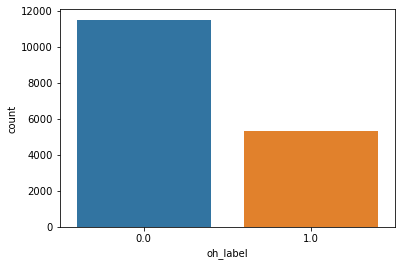

In [267]:
sns.countplot(x="oh_label",data=df)

In [268]:
df['oh_label'].value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [269]:
## lets check the % of data
5347/(11501+5347)

0.3173670465337132

### 30% data is in class 1, its not a very skwed data.

### Find the lengh of Text and see the sentiment

In [352]:
df['Text_len']= df['Text'].apply(lambda x: len(str(x)))

In [271]:
df

,index,id,Text,Annotation,oh_label,Text_len
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,140
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,140
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,91
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,83
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0,22
...,...,...,...,...,...,...
16846,5.75606766236475E+017,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0,95
16847,5.72333822886326E+017,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,85
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,140
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,82


In [353]:
df.drop(columns=['index','id','Annotation'],inplace=True)

In [354]:
df

,Text,oh_label,Text_len
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83
4,#mkr No No No No No No,0.0,22
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,95
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82


## plot length column and review 

In [274]:
df['Text_len'].describe()

count    16851.000000
mean        95.461812
std         37.570961
min          1.000000
25%         64.000000
50%        102.000000
75%        131.000000
max        162.000000
Name: Text_len, dtype: float64

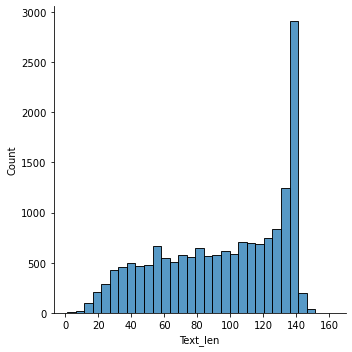

In [275]:
sns.displot(df['Text_len'])

### very few twits are of more length

In [355]:
df[df['Text_len'] >= 140]

,Text,oh_label,Text_len
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,140
10,@dllvllHllvllb @hyperion5182 @PolitiBunny @The...,0.0,140
16,RT @nathanrodger: If Kat &amp; Andre were drow...,0.0,148
...,...,...,...
16828,"RT @Janx53: @Firyayek Good vid! ""When we advan...",0.0,140
16837,RT @pperrin: Oh... so Rotherham was Tony Blair...,0.0,140
16841,yeah so annoying how they're doing their jobs ...,1.0,140
16843,@jukes303 The old oil cliche again. The US pay...,0.0,140


## Plot distribution fo different sentiment

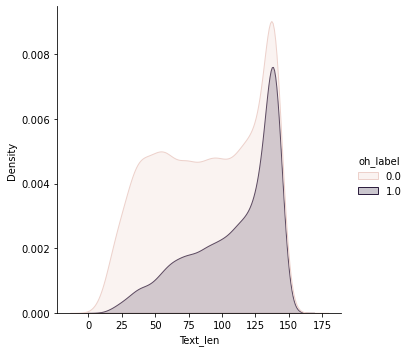

In [277]:
sns.displot(data=df,x='Text_len',hue='oh_label',kind='kde',fill=True)

## Data Cleaning

In [21]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [356]:
df['Cleaned_text'] = df['Text']

In [357]:
df.isna().sum()

Text            1
oh_label        3
Text_len        0
Cleaned_text    1
dtype: int64

In [358]:
df.dropna(inplace=True)

## Spell check 

In [238]:
# # def spell_correct(text):
# #     sample = text
# #     sample = TextBlob(sample)
# #     return sample.correct()
# df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x: str(TextBlob(x).correct()))
# df

In [553]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub('\w*\d', '', sample) #digits with trailing or preceeding text
    
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [360]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x: clean_text(x))
df

,Text,oh_label,Text_len,Cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call me but when i go to an auto place id rath...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong the example of and the exactly
4,#mkr No No No No No No,0.0,22,no no no no no no
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,95,feeling so sorry for the they should be safe a...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85,pretty good were happy with well never eating ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140,lemon we please go just one season of without ...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82,you are too stupid to talk to blocked


In [317]:
def display(text):
    print(text)

In [243]:
df['Cleaned_text'].apply(lambda x: display(x))

i read them in change in meaning the history of slavery
now you claim that people who tried to stop him from becoming a terrorist made him a terrorist brain dead
call me but when i go to an auto place id rather talk to a guy
wrong the example of and the exactly
preacher who and tortured his five daughter to death is after
not but most are bad
going to make some any but i
how dare you have is a fantastic way to dehumanize someone
theres something wrong when a girl street striker
not on the and i dont run blocking manually for now
a good is good despite his bad religion not because of it
i help everyone that not here to pass judgment on anyone that comes looking for help
yeah its about human life idiot something a genocidal wouldnt understand
eventually most of them were like wait harper harper and i still dont know how to adjust to this
the delusion factory is running full speed and the are
if kat were in a river you only had the chance to save one of them what type of sandwich would yo

still at the stage where given up on finding a good task list that with my so i use a
oh how strange glorious leader of a campaign that is supposedly not about harassment is harassment
oh if only colin washed his hair
really it out this year
court armed wing as terrorist organization
so the general leading the assault on in is from the action not my of valiant leadership
it read to me like you like him he yr book
strategic or talentless hack you be the judge
and here comes the kitchen crew
was king he could do what he none of your garbage any bearing on being a
they are trying to replace with a gal on the dollar bill not but spend all our money anyway
do you even plate
oh i didnt know you were coming to from via
when you have that many you know precisely what
the idea that the us is trying to provoke russia in light of invasion of and e is absurd
i thought we were through the instant restaurant please not another
ready to run was on and i
id score just to kick crazy out
and calling it 

kat you snake even if you win and open your own restaurant going to go
believe that the existence of a rape culture is solely down to the
i think that your are telling you stuff to jack up moral and they will try something but it will fail see
just kat and it was the best thing viva la
kat and got through on strategy and not score how embarrassing you should be ashamed or the biggest loser
and are going down to sudden death town
twitter is that what i keep the wrong button
cant lie this was generally clever funny and relatable without it with girlishness
why do continually cook they have never done or use they have never used
another job rejection
kat and dont deserve to stay in the competition its about good cooking not strategic voting
kat you are the biggest mole i hope you choke
call me but the sound of female hockey screeching at the ice from is causing me pain id rather hear
again again u want us to go this again give us a break stop treating the golden goose like
for the who is 

someone else which people are actively searching her name which is still creepy
we want to stay in this competition because we havent finished telling everyone how pretty we are
pete would love it
what are you stupid there is nothing that to the inhumanity and barbarity of
no more so than the who consider their birthright to be global domination
after that knockout round this is how many are left on my kitchen
are looking delicious
thats why there are many p matching or is
just discovered what when jeans are too big while wearing over a swim whelp time to make a belt
was a murderer wasnt was a rapist wasnt
not but i dont think are funny
never stopped its war on never stopped its war on humanity
which is fine i guess but she went out of her way to talk to interesting no
the were really thinking ahead when they sent to all those religious
if i was looking for id point out a white dude in a position of power accused a minority of bullying him p
dump the guy bring back
basically the are a 

when are the food trucks make a comeback
been told pretty good at drumming up suspense
we wish it were only a few
me too oddly not a bit
not but something aint right when calling a football game
not ignore the she received as well
the fact that you dont think this tripe is is the part
and is a total fruit cake kat is so delusional that a better grip on reality
insane to allies and then wonder why you have so few thats why radical feminism al
it was the best of times it was the worst of times but she had amazing i say
trying so hard to be charming i have nothing to add
lots of willing to give u that punch missing colin
thats just a one
ago my ass that was the beginning and it never stopped it is an ingrained part of
when a girl more buff than me
courtesy of our friend the of the board
exactly how is any male supposed to protect himself against the scenario u
since both the and your prophet and you are talking like a hypocrite
thats not what i with dumb but yeah i see what u mean the fac

is a fork that is mostly funded by the organization that marketing its a on top of
think we can all agree kat and will not get choice
look dude i want to be nice to you but off you got by a bot leave me alone
ranch dressing on pizza no pineapple was bad enough from these
and yet you felt the need to tweet this drivel
all that collusion in the community sure is hard to keep track of
how unfortunate theyre
multiple this is all a lot of effort though most just pick a new target
nice interface much than the setup that
your logic is dont touch that pile of trash because theres another pile under it
kat the only in history to give a and all for strategy you dont deserve to be in the competition
how is this a thing
lemon tart
so hilarious u write ur own material a lot of call me but those are and their dont matter
ben open to meeting good like but can i say nicely all a lemming
i actually got an answer from a feminist today a remarkably stupid one but an answer nonetheless
no in want to creat

this is basically going to be like but for p
now go back and see where the rank
what the hell were you thinking with your name
people say write what you know sometimes i think people should know more at
call me but if you need a specific training segment for coaching it the purpose of equality across
not to mention these same on have super inflated considering they didnt cook that well and arent very nice
at this rate maybe theyll all be rocking up to my house soon a meal surprise round
na na na na na na na na na na na na na na na na not but female are all
my face every time i hear or see it dont get stuck
unfortunately russia is a source of terror all those in e are not there for humanitarian reason
they made in the past i hope learned but the way they the situation been outstanding
sorry wat
i would have to do a search so forget that one for now
charity auction p
he got one serve not two had to defend the also
go the fake tan on one of the way too powdery
this is the joke
hey thought

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

In [361]:
only_english = set(nltk.corpus.words.words())
def remove_otherlanguage(text):
    sample = text
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    return sample

In [362]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x: remove_otherlanguage(x))

In [363]:
df

,Text,oh_label,Text_len,Cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call me but when i go to an auto place id rath...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong the example of and the exactly
4,#mkr No No No No No No,0.0,22,no no no no no no
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,95,feeling so sorry for the they should be safe a...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85,pretty good were happy with well never eating ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140,lemon we please go just one season of without ...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82,you are too stupid to talk to blocked


In [247]:
df['Cleaned_text'].apply(lambda x: display(x))

i read them in change in meaning the history of slavery
now you claim that people who tried to stop him from becoming a terrorist made him a terrorist brain dead
call me but when i go to an auto place id rather talk to a guy
wrong the example of and the exactly
preacher who and tortured his five daughter to death is after
not but most are bad
going to make some any but i
how dare you have is a fantastic way to dehumanize someone
theres something wrong when a girl street striker
not on the and i dont run blocking manually for now
a good is good despite his bad religion not because of it
i help everyone that not here to pass judgment on anyone that comes looking for help
yeah its about human life idiot something a genocidal wouldnt understand
eventually most of them were like wait harper harper and i still dont know how to adjust to this
the delusion factory is running full speed and the are
if kat were in a river you only had the chance to save one of them what type of sandwich would yo

camper whats bubble squeak its like leftover roast you need to work on your pitch
maple bacon how can you go wrong
i am offended by the grammar
will the dev that never forgotten to put in sleep or increment or wrote a poorly designed loop please stand up
order all to vacate their bases and move all from coalition after k
dont think that it wont go dont put on a cape unless you plan on being a hero its not a photo its a job
oh gosh no the problem is that been traveling and forgot to do my garrison stuff
yeah i something that mounted directly to my desk i get and move furniture sometimes
painting as inhuman is exactly what the does to
kim un
used to be
maybe you should teach that respect to like these
i think and tony might be in trouble if they scrape through be because they are than the
even if kat gave them the they they still would be there and the still gone home
i cant stand kat
based on based on kat it out
kat is fair hypocrite
because that like torture to me how can you defend it

and annoy me
absolutely still cracking up that the one time i wear a superhero cape on i run into someone that i know
well they there dessert
ash and camilla looking great at the today port
hooked up to all brains while driving
is for what doing i want something more
i am seriously considering not watching just because i have to see face god i want to slap it with a spatula
every guy that the only thing that will make a woman happy is making any man a sandwich
hope they get booted next round
alima have you how in the slave market
they are a laugh arent they
sometimes my such stupid that i have to remind myself that i her from knowing about much of the horrible stuff
but for someone who on their twitter account you are being rather you not
dont do i the bot
become a v showdown who can talk more talk
its like reading easy to spend too much time reading garbage instead of doing cool
video of execution was broadcast on big and you can hear yelling
therefore resulting in the fact that every

in the wake of the it me off to hear the to lessen role
not sure was sent
with the knowledge that your are reading and their hearts ring out in concert and support even if quietly
yeah let the have it and hope they come for us last
thats actually so kat and suck hair they should of gone they cant cook they are
alima the were won because gave his of what they stole
back then men were in charge and were to them today are just as equal and even better not sex
i it too funny i saw this one today
laughing kat and laugh at and not doing well and then they completely fail
this is a museum piece sir
calm your hair
state men in after their fail to wear new
one more propaganda troll blocked
hell yeah awesome post on
as of tonight i am officially finished with this show seen plenty of before but this is ridiculous m
i love it when these compromise their because the channel script tell them to no credibility
thats old school i didnt even think of that
main road junction is under control of we keep

your joke is like misogynist magnetic poetry thrown haphazardly onto a
i know you cant leave country without male permission
and if someone to leave then him an apostate and that he be
should never participate in no shave you should only have hair on your head
white house to call while on state t
i know what a straw man is what is the straw man here
kat and much
driverless that would be an improvement for some of the on the road
the confidence was way too much
the fat south are feeling hopeful
about to meet this puppy shepherd mix a bit bigger than i well see
not a fan of chicken liver entree
no i block quickly from my the go to my phone but always willing to unblock
theres a police boat over there this is a crime against cooking i fully approve now of colin being a jud
where is the location of
there is nothing incorrect about the generalization look at minority in
i dont even know what that is or where its from was that supposed to be funny it wasnt
big deal the spell checker its own 

kat and the competition only a short time showing yourself as to all of is going to last a lot longer
are so trained to see as quiet that when we engage with substance its seen as sudden aggression
yes amnesty will put us over the edge fiscally and crime and death will skyrocket
this could be close
i spy my with little eye two missing
i have no idea is going on or why i am in this tweet
its actually two separate real insane
the question is if are being targeted not if that are getting some damage
like cracker patriarch is at it again
to all you people saying dragging on theres an after these instant its only more
i the end of to watch what
the old school is not just old school
not sure how much more of this crap i can endure
if you tell me to get one of those weird hexa i will never talk to you again
funny as a in an elevator they have this lemon tart worse than did
yep except the study author it does not prove bias
i think i just got turned off lemon
exactly is really not theirs to re

learn how to tell other they should study something other than
listening to on satellite radio and sorry but these are awful not but the woman ann
theres also that made about a fever which turned into a heart attack in later of the story
my they argue to deny men choice they literally argue abortion is not a reproductive right
then shut down any imam and mosque that is the home mosque for anyone joining terror
she will often not know it should be opt in not opt out so that he must be told or else they will hide it
at if you need my pager address for urgent i can give that to you
i love how auto everything like this even when you say theyre
face at the table on hearing strategic scoring delusion
kind of want to jump through my and punch kat in the face hope other vote strategically for her now bitch
face palm face palm the model show is i watch for the cooking
cant sleep and came across this
nothing like a little colin to cheer up this night after a day
happy birthday
even if i didnt li

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

## remove stop words

In [364]:
stops = set(stopwords.words('english'))
def remove_stop_words(text, cores = 2):
    
    sample = text
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    return sample

In [365]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :remove_stop_words(x))
df

,Text,oh_label,Text_len,Cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,read change meaning history slavery
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,claim people tried stop becoming terrorist mad...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong example exactly
4,#mkr No No No No No No,0.0,22,
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,95,feeling sorry safe kat going home
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85,pretty good happy well never eating place
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140,lemon please go one season without someone cal...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82,stupid talk blocked


In [250]:
df['Cleaned_text'].values

array(['read change meaning history slavery',
       'claim people tried stop becoming terrorist made terrorist brain dead',
       'call go auto place id rather talk guy', ...,
       'lemon please go one season without someone calling something',
       'stupid talk blocked',
       'protest mad theres much reason youd feminism'], dtype=object)

In [366]:
df.isnull().sum()

Text            0
oh_label        0
Text_len        0
Cleaned_text    0
dtype: int64

## we hve some rows removed while removing stop words

In [367]:
df[df['Cleaned_text'] == ""]

,Text,oh_label,Text_len,Cleaned_text
4,#mkr No No No No No No,0.0,22,
72,Cc @SwiftOnSecurity http://t.co/RK2U5igiwU,0.0,42,
88,@mistertodd yessssss.,0.0,21,
108,@harmlesstree2 Here2. https://t.co/xWJzpSodGj,0.0,46,
124,@OdiniaInvictus @SirajZarook @BilalIGhumman @I...,0.0,137,
...,...,...,...,...
16771,@ROJNAME_english http://t.co/Ej5MsCentH,0.0,39,
16794,@dankmtl @AAlwuhaib1977 @PeaceNotHate_ No assh...,1.0,126,
16809,Portland IKEA: now with birds!,0.0,30,
16813,@randi_ebooks @desertfox899 what,0.0,32,


In [253]:
## replace empty rows with np.nan and drop those rows

In [368]:
df['Cleaned_text'].replace('', np.nan, inplace=True)
df.dropna(subset=['Cleaned_text'], inplace=True)
df.reset_index(inplace=True)

In [369]:
df

,index,Text,oh_label,Text_len,Cleaned_text
0,0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,read change meaning history slavery
1,1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,claim people tried stop becoming terrorist mad...
2,2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call go auto place id rather talk guy
3,3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong example exactly
4,5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,140,preacher tortured five daughter death
...,...,...,...,...,...
16073,16846,"Feeling so sorry for the girls, they should be...",0.0,95,feeling sorry safe kat going home
16074,16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85,pretty good happy well never eating place
16075,16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140,lemon please go one season without someone cal...
16076,16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82,stupid talk blocked


In [256]:
df['Cleaned_text'].apply(lambda x: display(x))

read change meaning history slavery
claim people tried stop becoming terrorist made terrorist brain dead
call go auto place id rather talk guy
wrong example exactly
preacher tortured five daughter death
bad
going make
dare fantastic way dehumanize someone
theres something wrong girl street striker
dont run blocking manually
good good despite bad religion
help everyone pass judgment anyone comes looking help
yeah human life idiot something genocidal wouldnt understand
eventually like wait harper harper still dont know adjust
delusion factory running full speed
kat river chance save one type sandwich would
literally site today
juxtaposition
woo cant wait see
tend document hair color later pic old
according holly shore sassy halfway slut classy
vomit
looking forward ash camilla butting drama great
food poisoning
brain dead repeat said million times
think two facing sudden death
time channel reconsider association dangerous man
male time collect trash
dont believe certain
sell get men
sure

want hear collusion
base army army one got close
complain quality historical context
physically n
gosh many surprise show need
surely dont anything masthead posting get damn person
men sold slavery love
get stuck head kat
u write come sign must tall ride emotional
like telling unlearn hatred
kat carol
p
experience similar key dont know twitter client additional
actually cant believe make pay food show
fear
catwalk place one foot front
explain
kat proof majority must wa one truly awful human bad though
god cant use opener joke know know blonde
news full white people dont understand killing demand see manager
raping world got size first
different racist equal nope salon
today one used word describe football defeat one step forward two back
new ghost woman cast wont
usually optimistic people ability change enough background story reliable
walter would love variety
coming hypocrite religion declared war humanity population
toss
hope pay
want destroy scum like excuse
oh
last night
ill take 

lack two replace one man
far many left show ago
disappointing made
bye bye ego might go notch
literally told dude could keep sponsorship money rather make effort include say aga
horse accepted multiple say must
double
friend zone please cut thanks management
massive forehead stays damn
love power brick hub big
saw phone didnt see salvation army
stopped would peace
random bombardment chemical chemical blown
often pay like problem charging
could hold still catch every night
either ignorant religion liar tell
love baking banana
thank random person said
two kelly group
part show awkward
bring back interesting thank god
start needs shut tech already
moment busy trying track conspiracy
amazing would never relive
oh kat never mind
really bad
obviously big boss fake ever seen woman little luggage
yet hear one good woman play play announcer
near danger meet
fight war earnest never know us
yet talk
tired strength defined solely upper body muscular strength inferior weak
dealing dont threaten app

ruby p doesnt good module streaming forced get better ruby good stuff
ill make simple
kat still wasnt biggest fan much kat
sure stream ill least vine making announcement ill
contact today find better
happiest ever
mad props well done
forgot annoying
early morning baking baked raspberry ripple cheesecake kitchen official site
female choose work
happy life cant tequila
today still peace
day day catch later hit medium emergency
thought would fairly easy implement get received blocked
list
sigh many people bad understanding dos
militia nearly inhuman
doesnt matter support since separation church state
old hat cleaning car job cutting grass job dish
dessert making lemon tart know
problem repress contradiction
many research exhaustive list
hate religion based hatred jihad
people assume saw blocked nope blocked knew use block list
test
domestic violence data lying
damn kat hope karma comes around arse
target demographic apparently fun fact draper tea
men use word ladies ladies pretty bad driv

bunch clip hair longer hair decided let use
block bot tool share block particular one via
theyll go away cuckoo
reverse doesnt exist murderous
meanwhile week one married bought sold
dog woke crying past cannot butt
bitch whore slut sick change speech change mind
yes try fool people believing lie religion peace
apparently
later
hey found oh whatever damsel distress oh gosh stop hapless victim
say
actually nothing think answer question
past allegedly even case gang f
cool story believe male female extent
receive code number must use title
minority next door murdering
would give ten push kat
break
strategic unfair voting dont like either team least werent like kat disappointed
yeah men beat point
know editor
love colin
terrorism formula ruin attempt get drive
rust course greedy private like north
yeah anti excuse anti
got get sheep feminist
must admit belong kitchen worth chuckle
love idiot national claim terrorism nothing one read
thats get family member random rage
whereas prostitution 

intent linking stated backing attempt save face apology
prophet rape like yes prophet tell cover stay home like yes
russia pess freedom
lunch prob busy p might able breakfast
proof liar propagandist
individual listing block list worn pride
love put kat place cook good food get good score
isolation
get page
wait
n best
many sound amazing wouldnt able make mind bacon
exactly
prophet used attack murdering crying
nothing religion
bring barely remember second group let alone first
race poop brains
guy harper met
breaking ambush near village
surely
cant wait see finally
could reformed
show end theyll spring another surprise round great great great g
nope democracy man vote sword two cannot coexist
want panel tech tearing
ghazi fire mob led
got one cheap way much fun
tough talk behind
never one perfect person someone massive
feather museum
kat get stay seriously unfair strategic scoring karma
upset arent getting free next three
ugh cant nothing quite degrading man feather duster
hope forget r

took male would
point live different
nervous kat tear new stays show
different impact depending power hard concept clarify
seen crap example never million
never thought id feel bad episode got right like punching
less bad genuinely equal equality la young
saw verbatim men selfish jerk think child
people right free speech would free speech
anyone video
tweet may actionable
always looking forward see rob outfit day
level transference tone deafness one amazing
claim dont need fought kind sick inhuman disgusting animal
sense also horrible block become muscle memory p
god series going end
thanks
sick word sassy
chapter history
sudden death kat funny would
feeling whole lot pain em
propaganda
world care declared war humanity ago
agree
hold phone kat cook crap think amazing
feeling quite sorry
hot pot especially drunk unconscious
wasnt aware man spoke miss memo
wasnt paying attention
surprise one dinner breakfast
dont support kind compare
time
honestly want meet guerrilla holding create token

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

In [370]:
only_english = set(nltk.corpus.words.words())

In [297]:
len(only_english)

235892

In [371]:
only_english = set(nltk.corpus.words.words())
def remove_non_eng_words(text):
    
    sample = text
    sample = [word for word in sample.split() if word in only_english]
    sample = ' '.join(sample)
    
    return sample

In [372]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :remove_non_eng_words(x))
df

,index,Text,oh_label,Text_len,Cleaned_text
0,0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,read change meaning history slavery
1,1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,claim people tried stop becoming terrorist mad...
2,2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call go auto place id rather talk guy
3,3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong example exactly
4,5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,140,preacher tortured five daughter death
...,...,...,...,...,...
16073,16846,"Feeling so sorry for the girls, they should be...",0.0,95,feeling sorry safe kat going home
16074,16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85,pretty good happy well never eating place
16075,16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140,lemon please go one season without someone cal...
16076,16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82,stupid talk blocked


In [373]:
df["Cleaned_text"] = df["Cleaned_text"].apply(lambda x: re.sub(' +', ' ', x))

In [374]:
df.head(10)

,index,Text,oh_label,Text_len,Cleaned_text
0,0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,read change meaning history slavery
1,1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,claim people tried stop becoming terrorist mad...
2,2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call go auto place id rather talk guy
3,3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong example exactly
4,5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,140,preacher tortured five daughter death
5,6,RT @Millhouse66 @Maureen_JS nooo not sexist bu...,1.0,74,bad
6,7,Going to make some pancakes.....Don't hve any ...,0.0,105,going make
7,8,RT @ahtweet: @freebsdgirl How dare you have fe...,0.0,94,dare fantastic way dehumanize someone
8,9,RT @Newmanzaa: There's something wrong when a ...,1.0,94,theres something wrong girl street striker
9,10,@dllvllHllvllb @hyperion5182 @PolitiBunny @The...,0.0,140,dont run blocking manually


## Lemmetaization

In [375]:
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('C'):
        return wordnet.NOUN
    else:
        return ''

# Lemmatizing the data
# Steps to convert : Document -> Sentences -> Tokens -> POS -> Lemmas
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text):
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ' '.join(sample)
    
    return sample

In [336]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :lemma_clean_text(x))
df

read change meaning history slavery
read NN
change NN
meaning NN
history NN
slavery NN
claim people tried stop becoming terrorist made terrorist brain dead
claim NN
people NNS
tried VBN
stop NN
becoming VBG
terrorist NN
made VBN
terrorist NN
brain NN
dead JJ
call go auto place id rather talk guy
call NN
go VB
auto NN
place NN
id NN
rather RB
talk NN
guy NN
wrong example exactly
wrong JJ
example NN
exactly RB
preacher tortured five daughter death
preacher NN
tortured VBN
five CD
daughter NN
death NN
bad
bad JJ
going make
going VBG
make VB
dare fantastic way dehumanize someone
dare NN
fantastic JJ
way NN
dehumanize VB
someone NN
theres something wrong girl street striker
theres NNS
something NN
wrong JJ
girl NN
street NN
striker NN
dont run blocking manually
dont NN
run VB
blocking VBG
manually RB
good good despite bad religion
good JJ
good JJ
despite IN


KeyError: ''

In [337]:
df['Cleaned_text'].apply(lambda x: display(x))

read change meaning history slavery
claim people tried stop becoming terrorist made terrorist brain dead
call go auto place id rather talk guy
wrong example exactly
preacher tortured five daughter death
bad
going make
dare fantastic way dehumanize someone
theres something wrong girl street striker
dont run blocking manually
good good despite bad religion
help everyone pass judgment anyone comes looking help
yeah human life idiot something genocidal wouldnt understand
eventually like wait harper harper still dont know adjust
delusion factory running full speed
kat river chance save one type sandwich would
literally site today
juxtaposition
woo cant wait see
tend document hair color later pic old
according holly shore sassy halfway slut classy
vomit
looking forward ash camilla butting drama great
food poisoning
brain dead repeat said million times
think two facing sudden death
time channel reconsider association dangerous man
male time collect trash
dont believe certain
sell get men
sure

wealthy
casting people trawl dark seriously delusional supremely misguided plain rotten
kat needs hat see go
apparently fascist run
twitter raping yesterday also saying get little bes
kat
cleric sun around earth understand skill jihad science
else looking forward kat pending elimination
star declared bankruptcy money ie multimillionaire sons guilty
monster
kat
squad retook south last night
whatever man woman never let go
honestly forgot name p doesnt really matter working real data
sorry call cannot respect opinion entertain sports even
hate big smug face constant split fringe much kat
incidentally know editor woman tech factual
could get hurt someone could come hell people shown office
someone valid emotional
similar talk ill writing regardless anyone west coast venue happy talk
cant stand female play play football every time hear holly game ca
already know reach doesnt really extend beyond follower count matter
military shipped
dont like wishing bad luck gosh really dislike kat much 

base army army one got close
complain quality historical context
physically n
gosh many surprise show need
surely dont anything masthead posting get damn person
men sold slavery love
get stuck head kat
u write come sign must tall ride emotional
like telling unlearn hatred
kat carol
p
experience similar key dont know twitter client additional
actually cant believe make pay food show
fear
catwalk place one foot front
explain
kat proof majority must wa one truly awful human bad though
god cant use opener joke know know blonde
news full white people dont understand killing demand see manager
raping world got size first
different racist equal nope salon
today one used word describe football defeat one step forward two back
new ghost woman cast wont
usually optimistic people ability change enough background story reliable
walter would love variety
coming hypocrite religion declared war humanity population
toss
hope pay
want destroy scum like excuse
oh
last night
ill take saying yes hit way
t

said yummy yummy yummy get
hey dad
wish bell would ring would rain every time said joke bingo card anticlimactic
men dont think ever envious men find feminine trait lots
pile manure human freedom human life human expression endless divisiveness
god truly projection
kat absolutely disgusting human
ill help dough coming
thats full never done days work
cannot stand feminist
tweet taken way pretty sure definition cant drunk
cant take action offering advice assistance person targeted report police
kat actually daughter found another use
thats definition call feel men appropriate life
name prominent please
yes
us keynote got show harassment happening live us harassment
graduated dos school flying colors
took village north tal afar
someone going home obviously cannot cook
reconstructed
every dev
algebra came
everybody passion million good
nothing gender like remake perfectly good film
nope eight little vermin al air base quickly
also angry worse death getting used
theres nothing female sports

kat loving negative
lone nut
us kill worthless without loosing man
number actually getting ridiculous stop show way much
walking wrong whole life
actually u need help call actually nancy warren
half dozen clearly document criminality good night
want toast
jelly much kat catch
turned tele spindle
hear hot pretty sassy like us one time
stop smiling kat
unfortunate id like leave twitter avenue available targeted
hit way wearing would
collective across country kat wont last
ever seen female even like behind wheel car
real attack al would yield killing ground lots open space hide behind
getting ready kill stuff
dont laugh kat
aw thanks p
notice didnt see kat cut
turkey going another secularism
blonde chick wearing hot pink dress
positive negative nancy thats corny
ease one scary least think acting rather th
always expect read
could stop watching crap like
refined pretty like something blind kindergarten student plate
read land oh salty small fish five new cook book cooking ahead
thanks thin

go vile inhuman religion
name many since twitter
utterly way kat better
question media see mention clem open bigotry nope narrative
head wiggle quagmire
need stay
glad hear peter respect assessment
kat awful wrong two
oh instant
reaction kat didnt get
interested childish
keep talking hot hot
trying decide time contact police call never thought id say unless involved
arent withdrawing silence talking abuse get end
cant believe page attack dont
need
anonymous
democracy bow turkey h
famous radical may next prime
oh look new idea synergistic cross promotional marketing paradigm thingy range
kat reckon may whole viewer population
mob violence
fair none anything even free speech matter p
husband pregnant wife sexual abuse
whatever country one group another
stop saying
alima nonsense like cult follower
dessert going
getting period thought dying
point pete appeal public
ever get dealing walking remember dont like
even going lie giggle little bit inside
corruption
hope try take wrestling respon

pocky
doesnt liberate anything dont want rest
going secular disgusting ever
monk touch karma someone else keep dont get killing blow credit teammate
real expansion already local loyalty worst worst
short hilarious fail ever seen
never used ice cream maker
hope dont go sudden elimination please
never thought id say hope butcher make tonight kat
didnt even say let alone undermine authority assume much step f
needs propaganda war publish
maybe learn lie
near
song ranked record received
equally
even cracked better
obviously student fed suck
could mayor heartbeat could murder blasphemy
al man savage way didnt rip
nobody dry sausage
false rape accusation might work
oh put bloody kat still
rest world every whim go enjoy shoot huge first foremost
russia sent arms port w air
hey everybody another funny thing
saw days ago brilliant need fifty like
realize powerful feminism really
dont care none business religion someone
oh south werent happy theyll gone soon
shut
ugh year
call whatever men shoul

kat class bad bra
view
pork like pork
bill warner versus
would rather involved debate
installer still install ask ugh oracle even go
theres still need island
view
gross
good time confront cult hatred murder
hope round cant cook
doubt especially respect men ever
thick juicy pork poor
kat make theyre seriously awful
lip freak
anyone else kat recently psych ward
last least bus talking ran friend
alima hello look research
best thing
think know way around well around
really enjoying one product stick gum also theres cupcake flavored please let cupcake pic
hear north glad made snow
doubt less true
thought female ghost could think
largely tempered former tax bracket although like idea flat tax doesnt work well
oh kat something new every night make look even like hateful twat
gay
used talk everything weird much attention
come joke men way round
actually even dictionary definition feminism unequal dont see telling
dont dare call dollar every time woman say men th
seven different married directl

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

In [332]:
nltk.pos_tag(['five'])[0][1]

'CD'

In [338]:
## Rmoving all single letters in the sentence

In [ ]:
' '.join( [w for w in input.split() if len(w)>1] )

In [376]:
def remove_single_char(text):
    
    sample = text.split()
    sample = [w for w in sample if len(w)>1]
    sample = ' '.join(sample)
    
    return sample

In [377]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :remove_single_char(x))
df

,index,Text,oh_label,Text_len,Cleaned_text
0,0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,read change meaning history slavery
1,1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,claim people tried stop becoming terrorist mad...
2,2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call go auto place id rather talk guy
3,3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong example exactly
4,5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,140,preacher tortured five daughter death
...,...,...,...,...,...
16073,16846,"Feeling so sorry for the girls, they should be...",0.0,95,feeling sorry safe kat going home
16074,16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85,pretty good happy well never eating place
16075,16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140,lemon please go one season without someone cal...
16076,16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82,stupid talk blocked


In [343]:
df[df['Cleaned_text'] == ""]

,Text,oh_label,Text_len,Cleaned_text
149,@JillWetzler I ❤️ u,0.0,19,
247,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,0.0,38,
333,.@rosesareswift K... http://t.co/IyxiisJajP,1.0,43,
1486,@shereeny @caulkthewagon there is. :P,0.0,37,
2943,@LewisDorigo no ms :P,0.0,21,
3718,"@aussielung And FYI ""Can u"" is asking YOU.",0.0,42,
4028,@g56yu Who?,0.0,12,
6523,@lethalcupcake awwwww! :P,0.0,25,
7422,@harmlesstree2 The Jews were murdered for 1400...,1.0,110,
9147,@nwOryzen Borrowed from Q on Startrek.,0.0,38,


In [378]:
df['Cleaned_text'].replace('', np.nan, inplace=True)
df.dropna(subset=['Cleaned_text'], inplace=True)
df.reset_index(drop=True,inplace=True)

In [379]:
df

,index,Text,oh_label,Text_len,Cleaned_text
0,0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,140,read change meaning history slavery
1,1,@ShreyaBafna3 Now you idiots claim that people...,0.0,140,claim people tried stop becoming terrorist mad...
2,2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,91,call go auto place id rather talk guy
3,3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,83,wrong example exactly
4,5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,140,preacher tortured five daughter death
...,...,...,...,...,...
16052,16846,"Feeling so sorry for the girls, they should be...",0.0,95,feeling sorry safe kat going home
16053,16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,85,pretty good happy well never eating place
16054,16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,140,lemon please go one season without someone cal...
16055,16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,82,stupid talk blocked


In [381]:
df[['Cleaned_text','oh_label']]

,Cleaned_text,oh_label
0,read change meaning history slavery,0.0
1,claim people tried stop becoming terrorist mad...,0.0
2,call go auto place id rather talk guy,1.0
3,wrong example exactly,1.0
4,preacher tortured five daughter death,0.0
...,...,...
16052,feeling sorry safe kat going home,0.0
16053,pretty good happy well never eating place,0.0
16054,lemon please go one season without someone cal...,0.0
16055,stupid talk blocked,0.0


In [382]:
df_final = df[['Cleaned_text','oh_label']]

In [383]:
df_final

,Cleaned_text,oh_label
0,read change meaning history slavery,0.0
1,claim people tried stop becoming terrorist mad...,0.0
2,call go auto place id rather talk guy,1.0
3,wrong example exactly,1.0
4,preacher tortured five daughter death,0.0
...,...,...
16052,feeling sorry safe kat going home,0.0
16053,pretty good happy well never eating place,0.0
16054,lemon please go one season without someone cal...,0.0
16055,stupid talk blocked,0.0


In [387]:
pickle.dump(df_final,open('data/twitter_cleaned.p', 'wb'))

In [399]:
df = pickle.load(open('data/twitter_cleaned.p','rb'))

## Word cloud for positive class

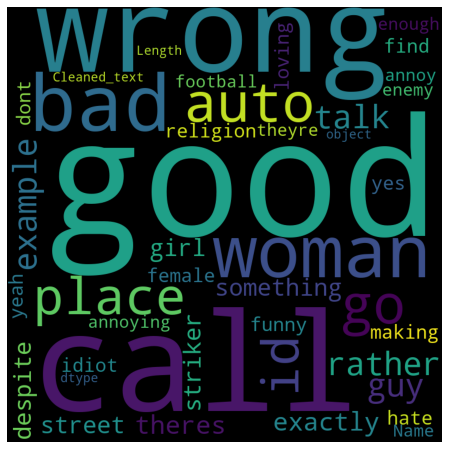

In [419]:
wc = str(df[df['oh_label']==1]['Cleaned_text'])

wordcloud = WordCloud(width =800,height=800,background_color='black',min_font_size=10).generate(wc)

plt.figure(figsize = (8,8),facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Word cloud for negative class

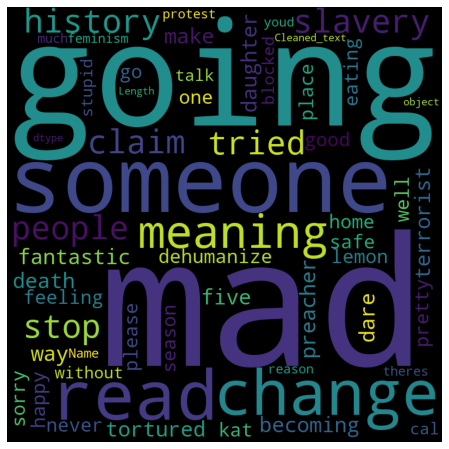

In [420]:
wc = str(df[df['oh_label']==0]['Cleaned_text'])

wordcloud = WordCloud(width =800,height=800,background_color='black',min_font_size=10).generate(wc)

plt.figure(figsize = (8,8),facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Bag of words -  Binary bag of word

In [431]:
vect_binary = CountVectorizer(binary=True)

In [432]:
X_BOW_Binary = vect_binary.fit_transform(df['Cleaned_text']) 

In [433]:
X_BOW_Binary.shape

(16057, 7559)

## Unique word in the vocabulaty

In [434]:
vect_binary.vocabulary_

{'read': 5290,
 'change': 1054,
 'meaning': 4048,
 'history': 3127,
 'slavery': 6048,
 'claim': 1160,
 'people': 4716,
 'tried': 6910,
 'stop': 6346,
 'becoming': 583,
 'terrorist': 6678,
 'made': 3914,
 'brain': 801,
 'dead': 1679,
 'call': 925,
 'go': 2854,
 'auto': 443,
 'place': 4821,
 'id': 3241,
 'rather': 5269,
 'talk': 6586,
 'guy': 2970,
 'wrong': 7514,
 'example': 2326,
 'exactly': 2322,
 'preacher': 4961,
 'tortured': 6829,
 'five': 2574,
 'daughter': 1674,
 'death': 1693,
 'bad': 489,
 'going': 2863,
 'make': 3943,
 'dare': 1662,
 'fantastic': 2456,
 'way': 7348,
 'dehumanize': 1742,
 'someone': 6145,
 'theres': 6709,
 'something': 6146,
 'girl': 2829,
 'street': 6373,
 'striker': 6381,
 'dont': 2007,
 'run': 5640,
 'blocking': 719,
 'manually': 3977,
 'good': 2871,
 'despite': 1815,
 'religion': 5415,
 'help': 3081,
 'everyone': 2310,
 'pass': 4655,
 'judgment': 3574,
 'anyone': 284,
 'comes': 1272,
 'looking': 3859,
 'yeah': 7527,
 'human': 3203,
 'life': 3771,
 'idiot': 

In [435]:
## Entire feature is saved as sparse matrix, we can comvert it to numpy array and see teh,m, but not recomented if teh size is big


### Experienting with numpy array`

In [436]:
X_a = X_BOW_Binary.toarray()

In [439]:
X_a.shape

(16057, 7559)

In [441]:
X_a[3,:]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [447]:
X_a[16054,:].sum()  ## there are 3 features in this vector respresetation., that means the sentence has 3 words

9

In [451]:
vect_binary.get_feature_names().index('stupid') ## check the index of the feature

6407

In [453]:
X_a[16055,6407]

1

## Split the data into train and test

In [518]:
y = df['oh_label']

In [519]:
def split_data(X,y):
    return (train_test_split(X,y, test_size=0.2,stratify=y,random_state=42))

In [520]:
X_train,X_test,y_train,y_test = split_data(X_BOW_Binary,y)

## Building Logistic Regression

In [521]:
lr = LogisticRegression()
lr.fit(X_train,y_train)


LogisticRegression()

### Training accuracy

In [522]:
def train_accuracy(model,X_train,y_train):    
    train_pred = model.predict(X_train)
    return accuracy_score(y_train,train_pred)
    

In [523]:
train_accuracy(lr,X_train,y_train)

0.8529388867263527

### Test accuracy

In [525]:
def test_accuracy(model,X_test,y_test):
    test_pred = model.predict(X_test)
    return accuracy_score(y_test,test_pred)

In [526]:
test_accuracy(lr,X_test,y_test)

0.7556039850560399

In [467]:
## ideally, we have to train the model with train and validation data and test the final decided model only with test data

## Save models

In [473]:
pickle.dump(lr,open('models/BOW_lr.p', 'wb'))
pickle.dump(vect_binary,open('models/BagOfWord_binary_vect.p','wb'))
pickle.dump(X_BOW_Binary,open('data/X_BOw_Binary_data.p','wb'))

## Bag of word - Non Binary

In [527]:
vect_non_Binary = CountVectorizer()  # this is not one hot encoding, insted, it gives the frequency of words
X_BOW_non_Binary = vect_non_Binary.fit_transform(df['Cleaned_text'])

In [528]:
X_BOW_non_Binary.shape

(16057, 7559)

## Split the data

In [529]:
X_train,X_test,y_train,y_test = split_data(X_BOW_non_Binary,y)

## Building Logistic Regression

In [530]:
lr_Bow_noBinary = LogisticRegression()
lr_Bow_noBinary.fit(X_train,y_train)

LogisticRegression()

In [531]:
train_accuracy(lr_Bow_noBinary,X_train,y_train)

0.853483845854418

In [532]:
test_accuracy(lr_Bow_noBinary,X_test,y_test)

0.7546699875466999

## Save models

In [543]:
pickle.dump(lr,open('models/lr_Bow_noBinary.p', 'wb'))
pickle.dump(vect_binary,open('models/vect_non_Binary.p','wb'))
pickle.dump(X_BOW_Binary,open('data/X_BOW_non_Binary_data.p','wb'))

## N-Grams

In [533]:
## We take of range of token, unigram, bigram, trigram

In [534]:
vect_n_gram_3 = CountVectorizer(ngram_range=(1,3))

In [535]:
X_n_gram_3 = vect_n_gram_3.fit_transform(df['Cleaned_text'])

In [536]:
X_n_gram_3.shape # this drastically increase teh features

(16057, 109173)

In [498]:
vect_n_gram_3.vocabulary_

{'read': 74058,
 'change': 13320,
 'meaning': 57654,
 'history': 41920,
 'slavery': 84082,
 'read change': 74080,
 'change meaning': 13350,
 'meaning history': 57662,
 'history slavery': 41982,
 'read change meaning': 74081,
 'change meaning history': 13351,
 'meaning history slavery': 57663,
 'claim': 14161,
 'people': 67020,
 'tried': 97249,
 'stop': 87846,
 'becoming': 7264,
 'terrorist': 92445,
 'made': 54925,
 'brain': 10039,
 'dead': 19665,
 'claim people': 14213,
 'people tried': 67751,
 'tried stop': 97277,
 'stop becoming': 87857,
 'becoming terrorist': 7291,
 'terrorist made': 92495,
 'made terrorist': 55100,
 'terrorist brain': 92459,
 'brain dead': 10050,
 'claim people tried': 14214,
 'people tried stop': 67752,
 'tried stop becoming': 97278,
 'stop becoming terrorist': 87858,
 'becoming terrorist made': 7292,
 'terrorist made terrorist': 92496,
 'made terrorist brain': 55101,
 'terrorist brain dead': 92460,
 'call': 11126,
 'go': 36460,
 'auto': 5590,
 'place': 68927,
 'i

## Split the data

In [537]:
X_train,X_test,y_train,y_test = split_data(X_n_gram_3,y)

In [538]:
X_train.shape

(12845, 109173)

## Building Logistic Regression

In [539]:
lr_n_gram_3 = LogisticRegression()
lr_n_gram_3.fit(X_train,y_train)

LogisticRegression()

In [540]:
train_accuracy(lr_n_gram_3,X_train,y_train)

0.9655897236278708

In [541]:
test_accuracy(lr_n_gram_3,X_test,y_test)

0.763387297633873

In [544]:
pickle.dump(lr,open('models/lr_n_gram_3.p', 'wb'))
pickle.dump(vect_binary,open('models/vect_n_gram_3.p','wb'))
pickle.dump(X_BOW_Binary,open('data/X_n_gram_3.p','wb'))

## TF-IDF

-  find the important of the word
-  if one word accurs more than one time in an document, that is important word for this document. - TF

-  TF(t,d) = no of time token occures in document/total number of words in document

 - TF alone is not enought - this could be common words, like stop words
 - we have to find the rare words wich are occuring in the document

 - idf = log (total number of document/total document wiht token in it)


In [608]:
vect_tfidf = TfidfVectorizer()
X_tf = vect_tfidf.fit_transform(df['Cleaned_text'])

In [609]:
X_tf.shape

(16057, 7559)

In [610]:
X_train,X_test,y_train,y_test = split_data(X_tf,y)
X_train.shape

(12845, 7559)

In [611]:
lr_tf = LogisticRegression()
lr_tf.fit(X_train,y_train)

LogisticRegression()

In [612]:
train_accuracy(lr_tf,X_train,y_train)

0.8045153756325418

In [613]:
test_accuracy(lr_tf,X_test,y_test)

0.7574719800747198

In [615]:
confusion_matrix(y_train,lr_tf.predict(X_train))

array([[8308,  332],
       [2179, 2026]], dtype=int64)

In [616]:
f1_score(y_train,lr_tf.predict(X_train))

0.6174005790035044

In [617]:
precision_score(y_train,lr_tf.predict(X_train))

0.8592027141645462

## Save model

In [573]:
pickle.dump(lr_tf,open('models/lr_tf.p', 'wb'))
pickle.dump(vect_binary,open('models/vect_tfidf.p','wb'))
pickle.dump(X_BOW_Binary,open('data/X_tf_data.p','wb'))

## Prediction on new data

In [579]:
## so far best on is n gram
twit_1 = """@scamp_faridxx @AbuAlbaraaSham Yeah, it's called caring about human life, idiot - something a genocidal Daesh would'nt understand. """ 
twit_2 = """ This home feels so good to stay and enjoying.!!!!"""

In [580]:
twit1 = clean_text(twit_1) ## clean test, with remove pantuations , lower
twit2 = clean_text(twit_2)

In [581]:
twit1

'yeah its about human life idiot something a genocidal wouldnt understand'

In [582]:
twit1 = remove_otherlanguage(twit1) ## remove other foriegn languages
twit2 = remove_otherlanguage(twit2)

In [583]:
twit1

'yeah its about human life idiot something a genocidal wouldnt understand'

In [584]:
twit1 = remove_stop_words(twit1) ## remove stop words
twit2 = remove_stop_words(twit2)

In [585]:
twit1

'yeah human life idiot something genocidal wouldnt understand'

In [586]:
twit2

'home good stay enjoying'

In [587]:
twit1 = lemma_clean_text(twit1) ## lemmetizer
twit2 = lemma_clean_text(twit2)

yeah human life idiot something genocidal wouldnt understand
yeah NN
human NN
life NN
idiot NN
something NN
genocidal NN
wouldnt NN
understand NN
home good stay enjoying
home NN
good JJ
stay NN
enjoying VBG


In [588]:
twit1

'yeah human life idiot something genocidal wouldnt understand'

In [589]:
twit2

'home good stay enjoy'

In [590]:
twit1 = remove_single_char(twit1) ## lemmetizer
twit2 = remove_single_char(twit2)

In [591]:
twit2

'home good stay enjoy'

In [592]:
## Load models

model = pickle.load(open('models/lr_tf.p','rb'))
vect = pickle.load(open('models/vect_tfidf.p','rb'))


In [597]:
## Apply vector
X_test1 = vect.transform([twit1])
X_test2 = vect.transform([twit2])

In [598]:
X_test.shape

(1, 7559)

In [600]:
model.predict_proba(X_test1)

array([[0.2760133, 0.7239867]])

In [601]:
model.predict(X_test1)

array([1.])

In [602]:
## IT predicted Positve

In [603]:
model.predict_proba(X_test2)

array([[0.75725392, 0.24274608]])

In [604]:
model.predict(X_test2)

array([0.])

## Although this model is predicting rightly, the f1 score is not high. we would need to train with different emeddings and algorithms